<a href="https://colab.research.google.com/github/matin/garth/blob/main/colabs/sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin sleep statistics

Start by installing and importing `garth`

In [1]:
%pip install garth >& /dev/null

In [2]:
import garth

Define Garth session location to save and resume sessions

In [3]:
GARTH_HOME = "drive/MyDrive/garth"

Mount Drive for saving and resuming sessions

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Resume session or login, and make sure to save the garth session for next time

In [5]:
from garth.exc import GarthException
from getpass import getpass

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (GarthException, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

## Daily sleep quality

List sleep quality for the past 7 days

In [6]:
garth.DailySleep.list(period=7)

[DailySleep(calendar_date=datetime.date(2023, 8, 10), value=79),
 DailySleep(calendar_date=datetime.date(2023, 8, 11), value=68),
 DailySleep(calendar_date=datetime.date(2023, 8, 12), value=73),
 DailySleep(calendar_date=datetime.date(2023, 8, 13), value=70),
 DailySleep(calendar_date=datetime.date(2023, 8, 14), value=75),
 DailySleep(calendar_date=datetime.date(2023, 8, 15), value=28),
 DailySleep(calendar_date=datetime.date(2023, 8, 16), value=42)]

Let's take a look at the sleep quality for the past 90 days

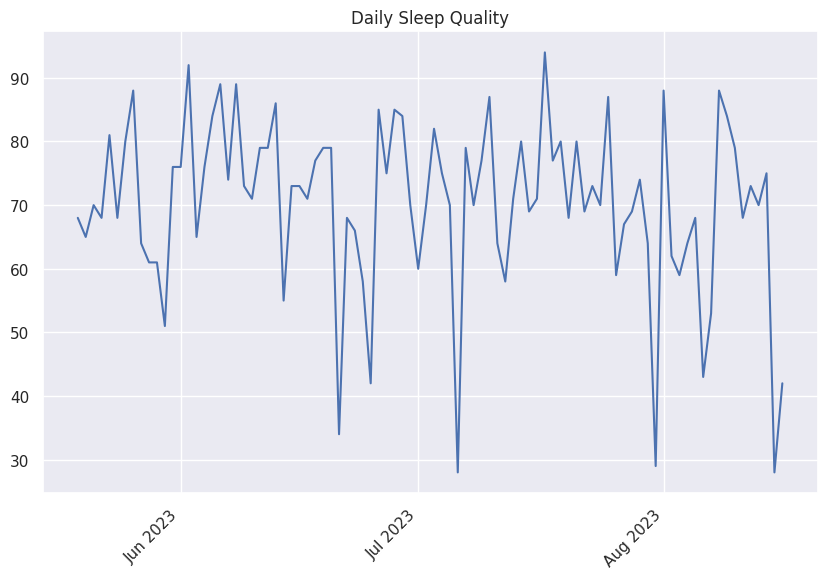

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

daily_sleep = pd.DataFrame(garth.DailySleep.list(period=90))

daily_sleep["calendar_date"] = pd.to_datetime(daily_sleep["calendar_date"])
daily_sleep.set_index("calendar_date", inplace=True)

sns.set_theme()

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_sleep, legend=False)

plt.ylabel(None)
plt.xlabel(None)
plt.title("Daily Sleep Quality")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45, ha="right")

plt.show()

## Daily sleep data (including stages)

Determine the latest date with sleep data

In [8]:
latest = garth.DailySleep.list(period=2)[-1].calendar_date

The sleep data includes a tremendous amount of information and can only be fetched by day. Let"s fetch every day for the 30 days leading up to yesterday

In [9]:
sleep_data = [sd.daily_sleep_dto for sd in garth.SleepData.list(latest, 90)]

Let's graph the sleep stages as a stacked bar graph

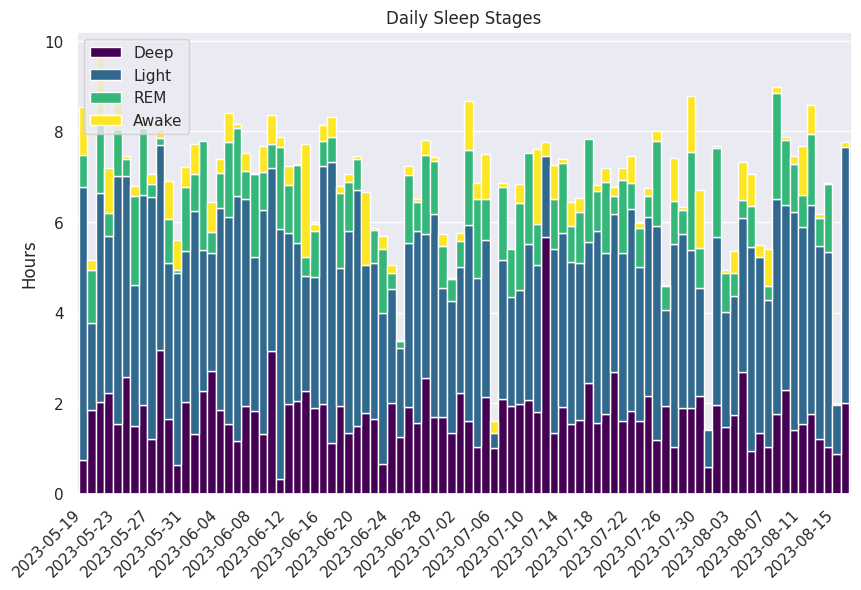

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(sleep_data)

df["deep_sleep_hours"] = (
    df["deep_sleep_seconds"] / 3600
)
df["light_sleep_hours"] = (
    df["light_sleep_seconds"] / 3600
)
df["rem_sleep_hours"] = (
    df["rem_sleep_seconds"] / 3600
)
df["awake_sleep_hours"] = (
    df["awake_sleep_seconds"] / 3600
)
df["calendar_date"] = (
    pd.to_datetime(df["calendar_date"]).dt.date
)

df.sort_values("calendar_date", inplace=True)
df.set_index("calendar_date", inplace=True)
df.rename(columns={
    "deep_sleep_hours": "Deep",
    "light_sleep_hours": "Light",
    "rem_sleep_hours": "REM",
    "awake_sleep_hours": "Awake"
}, inplace=True)

sns.set_theme()

ax = df[["Deep", "Light", "REM", "Awake"]].plot(
    kind="bar", stacked=True, figsize=(10, 6), grid=True, colormap="viridis",
    width=1
)

plt.ylabel("Hours")
plt.xlabel(None)
plt.title("Daily Sleep Stages")
plt.grid(axis="x")
plt.legend(loc="upper left")
labels = ax.get_xticklabels()
ticks = ax.get_xticks()
ax.set_xticks([tick for i, tick in enumerate(ticks) if i % 4 == 0])
ax.set_xticklabels([label for i, label in enumerate(labels) if i % 4 == 0])
plt.xticks(rotation=45, ha="right")

plt.show()

Look at the time of day for when we went to sleep and woke up

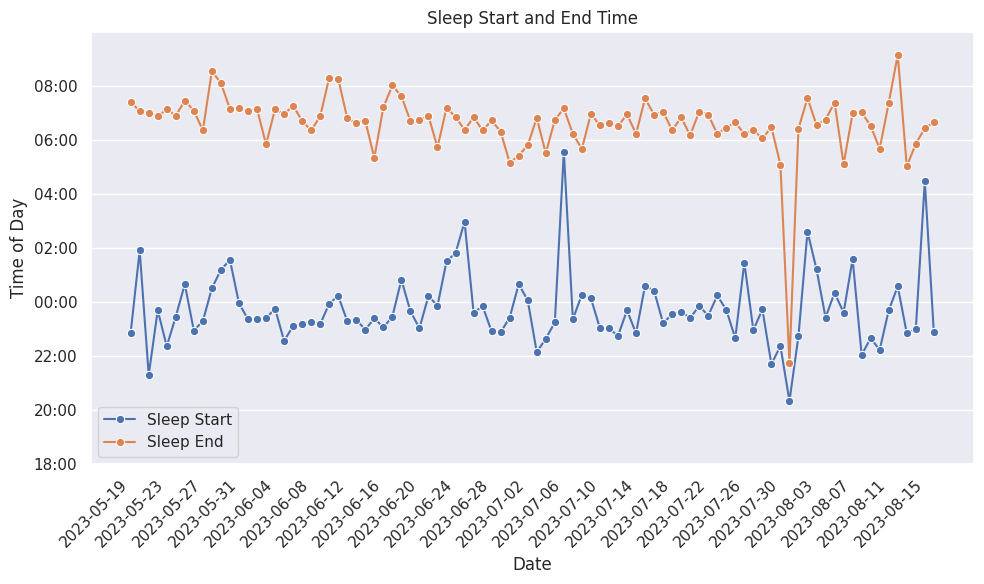

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame(sleep_data)
df.sort_values("calendar_date", inplace=True)
df.set_index("calendar_date", inplace=True)

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Get the provided timestamp columns (in milliseconds)
start_col = "sleep_start_timestamp_local"
end_col = "sleep_end_timestamp_local"

# Convert the timestamps (in milliseconds) to hours and minutes
df["sleep_start_time"] = pd.to_datetime(df[start_col], unit="ms").dt.time
df["sleep_end_time"] = pd.to_datetime(df[end_col], unit="ms").dt.time

# Convert time to hours, with 18:00 as the starting point
def convert_time(time_obj):
    hours_from_18 = time_obj.hour + time_obj.minute / 60 - 18
    return hours_from_18 if hours_from_18 >= 0 else hours_from_18 + 24

df["sleep_start_hours"] = df["sleep_start_time"].apply(convert_time)
df["sleep_end_hours"] = df["sleep_end_time"].apply(convert_time)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y="sleep_start_hours", label="Sleep Start", marker="o")
sns.lineplot(data=df, x=df.index, y="sleep_end_hours", label="Sleep End", marker="o")

# Formatting
plt.title("Sleep Start and End Time")
plt.ylabel("Time of Day")
plt.xlabel("Date")
plt.grid(axis="x")
plt.xticks(df.index[::4], rotation=45, ha="right")
plt.yticks(range(0, 16, 2), [f"{(h + 18) % 24:02d}:00" for h in range(0, 16, 2)])
plt.ylim(0, 16)
plt.tight_layout()
plt.legend()
plt.show()
